__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.3　売上予測モデルを活用したデータドリブン販促（小売りチェーン）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from pmdarima.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution
from optuna.distributions import IntDistribution

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_2.csv'
df=pd.read_csv(dataset)

print(df) #確認

           date day_of_the_week       y1  y21   y22    x1    x2     x3    x4  \
0      2016/6/6             Mon   818979  177  4627  18.3   0.0  0.006     0   
1      2016/6/7             Tue   789332  164  4813  19.8   0.9  0.002     0   
2      2016/6/8             Wed   793266  141  5626  22.8   0.5  0.002     0   
3      2016/6/9             Thu   721415  157  4595  23.1   7.0  0.005     0   
4     2016/6/10             Fri   796138  146  5453  22.2   0.0  0.003     0   
..          ...             ...      ...  ...   ...   ...   ...    ...   ...   
136  2016/10/20             Thu   799006  158  5052  20.8   0.0  0.002     0   
137  2016/10/21             Fri   822875  145  5687  17.8   0.5  0.007     0   
138  2016/10/22             Sat  1326138  142  9433  17.7  82.9  0.229  7500   
139  2016/10/23             Sun  1392365  155  9087  16.9  76.5  0.225  7500   
140  2016/10/24             Mon   689187  107  6403  17.3  10.8  0.010     0   

     holiday  
0          0  
1        

### 曜日ダミー変数を作る

In [3]:
#
# 曜日のダミー変数（One-Hotエンコーディング）生成
#

# 曜日リスト
week_list = ['Tue','Wed','Thu','Fri','Sat','Sun','Mon']

# インスタンス生成
enc = OneHotEncoder(
    categories=[week_list],sparse=False)

# One-Hotエンコーディングの実施
week_d = enc.fit_transform(df[['day_of_the_week']])

# データフレーム化
df_week_d = pd.DataFrame(
    week_d,
    index=df.index,
    columns=week_list,
    dtype='int')

# 確認
print(df_week_d)

     Tue  Wed  Thu  Fri  Sat  Sun  Mon
0      0    0    0    0    0    0    1
1      1    0    0    0    0    0    0
2      0    1    0    0    0    0    0
3      0    0    1    0    0    0    0
4      0    0    0    1    0    0    0
..   ...  ...  ...  ...  ...  ...  ...
136    0    0    1    0    0    0    0
137    0    0    0    1    0    0    0
138    0    0    0    0    1    0    0
139    0    0    0    0    0    1    0
140    0    0    0    0    0    0    1

[141 rows x 7 columns]


In [4]:
#
# 元のデータセットに結合
#

df = pd.concat([df, df_week_d], axis=1)

print(df) #確認

           date day_of_the_week       y1  y21   y22    x1    x2     x3    x4  \
0      2016/6/6             Mon   818979  177  4627  18.3   0.0  0.006     0   
1      2016/6/7             Tue   789332  164  4813  19.8   0.9  0.002     0   
2      2016/6/8             Wed   793266  141  5626  22.8   0.5  0.002     0   
3      2016/6/9             Thu   721415  157  4595  23.1   7.0  0.005     0   
4     2016/6/10             Fri   796138  146  5453  22.2   0.0  0.003     0   
..          ...             ...      ...  ...   ...   ...   ...    ...   ...   
136  2016/10/20             Thu   799006  158  5052  20.8   0.0  0.002     0   
137  2016/10/21             Fri   822875  145  5687  17.8   0.5  0.007     0   
138  2016/10/22             Sat  1326138  142  9433  17.7  82.9  0.229  7500   
139  2016/10/23             Sun  1392365  155  9087  16.9  76.5  0.225  7500   
140  2016/10/24             Mon   689187  107  6403  17.3  10.8  0.010     0   

     holiday  Tue  Wed  Thu  Fri  Sat  

### 三角関数特徴量を作る

In [5]:
#
# 三角関数特徴量の生成
#

# 空のデータフレーム生成
df_week_ft = pd.DataFrame()
df_week_ft.index = df.index

# Fourier termsの生成関数
def fourier_terms_gen(X, seasonal, terms_num):
    
    #seasonal:周期
    #terms_num:Fourier termの数（sinとcosのセット数）
    
    for num in range(terms_num):
        num = num + 1
        sin_colname = 'sin'+str(seasonal)+'_'+ str(num)
        cos_colname = 'cos'+str(seasonal)+'_'+ str(num)

        X[sin_colname] = np.sin(num*2*np.pi*X.index/seasonal)
        X[cos_colname] = np.cos(num*2*np.pi*X.index/seasonal)

# 三角関数特徴量の生成
fourier_terms_gen(df_week_ft, seasonal=7,terms_num=3)
    
print(df_week_ft) #確認

           sin7_1    cos7_1        sin7_2    cos7_2        sin7_3    cos7_3
0    0.000000e+00  1.000000  0.000000e+00  1.000000  0.000000e+00  1.000000
1    7.818315e-01  0.623490  9.749279e-01 -0.222521  4.338837e-01 -0.900969
2    9.749279e-01 -0.222521 -4.338837e-01 -0.900969 -7.818315e-01  0.623490
3    4.338837e-01 -0.900969 -7.818315e-01  0.623490  9.749279e-01 -0.222521
4   -4.338837e-01 -0.900969  7.818315e-01  0.623490 -9.749279e-01 -0.222521
..            ...       ...           ...       ...           ...       ...
136  4.338837e-01 -0.900969 -7.818315e-01  0.623490  9.749279e-01 -0.222521
137 -4.338837e-01 -0.900969  7.818315e-01  0.623490 -9.749279e-01 -0.222521
138 -9.749279e-01 -0.222521  4.338837e-01 -0.900969  7.818315e-01  0.623490
139 -7.818315e-01  0.623490 -9.749279e-01 -0.222521 -4.338837e-01 -0.900969
140 -4.898587e-15  1.000000 -9.797174e-15  1.000000  1.372595e-14  1.000000

[141 rows x 6 columns]


In [6]:
#
# 元のデータセットに結合
#

df = pd.concat([df, df_week_ft], axis=1)

print(df) #確認

           date day_of_the_week       y1  y21   y22    x1    x2     x3    x4  \
0      2016/6/6             Mon   818979  177  4627  18.3   0.0  0.006     0   
1      2016/6/7             Tue   789332  164  4813  19.8   0.9  0.002     0   
2      2016/6/8             Wed   793266  141  5626  22.8   0.5  0.002     0   
3      2016/6/9             Thu   721415  157  4595  23.1   7.0  0.005     0   
4     2016/6/10             Fri   796138  146  5453  22.2   0.0  0.003     0   
..          ...             ...      ...  ...   ...   ...   ...    ...   ...   
136  2016/10/20             Thu   799006  158  5052  20.8   0.0  0.002     0   
137  2016/10/21             Fri   822875  145  5687  17.8   0.5  0.007     0   
138  2016/10/22             Sat  1326138  142  9433  17.7  82.9  0.229  7500   
139  2016/10/23             Sun  1392365  155  9087  16.9  76.5  0.225  7500   
140  2016/10/24             Mon   689187  107  6403  17.3  10.8  0.010     0   

     holiday  ...  Fri  Sat  Sun  Mon  

### 学習データとテストデータ（直近21日間）に分割

In [7]:
#
# データセットを学習データとテストデータ（直近21日間）に分割
#

target_length = 21

df_train, df_test = train_test_split(
    df,test_size=target_length)

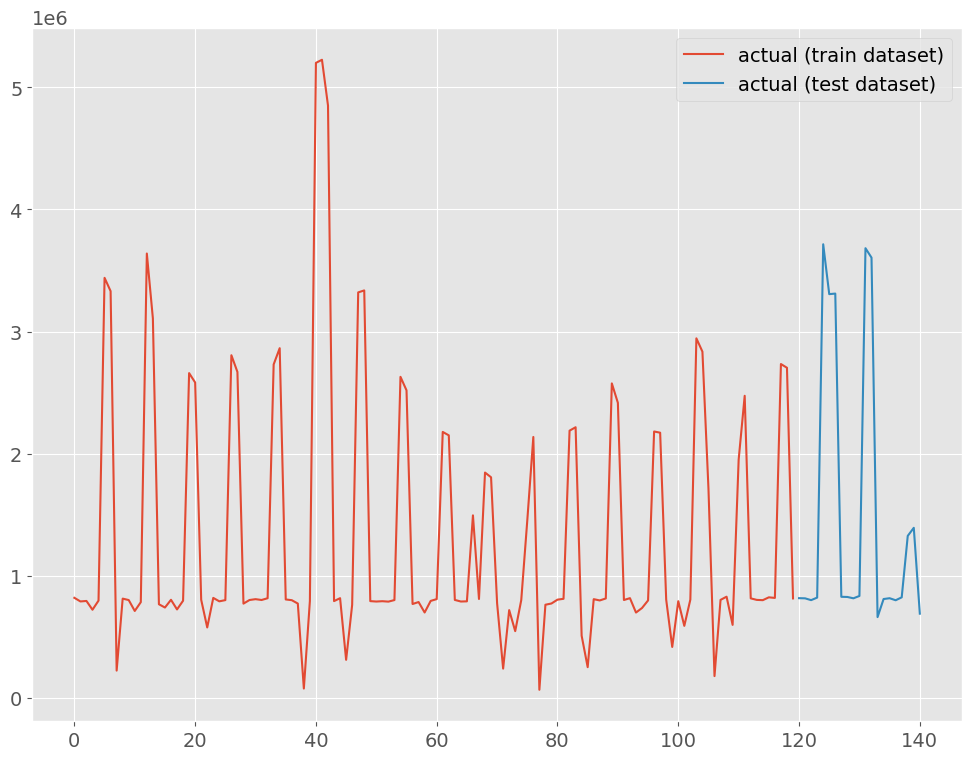

In [8]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(
    df_train.index, 
    df_train.y1, 
    label="actual (train dataset)")
ax.plot(
    df_test.index, 
    df_test.y1, 
    label="actual (test dataset)")

plt.legend()
plt.show()

## ステップ2：予測モデルの作り方の検討

### パターン1：説明変数x1からx4、休日フラグ変数（holiday）

#### 目的変数yと説明変数X

In [9]:
#
# パターン1｜目的変数yと説明変数X
#

# 変数選択リスト（True:変数として残す）
x_list = [
    False,False,False,False,False,
    True,True,True,True,True, #x1,x2,x3,x4,holiday
    False,False,False,False,False,False,False, #day_of_the_week
    False,False,False,False,False,False #Fourier terms
]

print(df[df.columns[x_list]]) #確認

# 学習データ
y_train = df_train.y1
X_train = df_train[df.columns[x_list]]

# テストデータ
y_test = df_test.y1
X_test = df_test[df.columns[x_list]]

       x1    x2     x3    x4  holiday
0    18.3   0.0  0.006     0        0
1    19.8   0.9  0.002     0        0
2    22.8   0.5  0.002     0        0
3    23.1   7.0  0.005     0        0
4    22.2   0.0  0.003     0        0
..    ...   ...    ...   ...      ...
136  20.8   0.0  0.002     0        0
137  17.8   0.5  0.007     0        0
138  17.7  82.9  0.229  7500        1
139  16.9  76.5  0.225  7500        1
140  17.3  10.8  0.010     0        0

[141 rows x 5 columns]


#### Ridge回帰

In [10]:
#
# ハイパーパラメータ探索
#

# Ridge回帰のインスタンス生成
regressor = Ridge()

# 探索するハイパーパラメータ範囲の設定
params = {
    'alpha': 
        FloatDistribution(0.001, 1e10)
}

# ハイパーパラメータ探索の設定
optuna_search = OptunaSearchCV(
    estimator=regressor,
    param_distributions=params,
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=123)

# 探索実施
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search.fit(X_train, y_train)

# 探索結果
print(optuna_search.best_params_)

{'alpha': 3030454909.8383036}


In [11]:
#
# 最適ハイパーパラメータで学習
#

# 最適なハイパーパラメータを設定
ridge_p1 = regressor.set_params(**optuna_search.best_params_)

# 学習データで学習
ridge_p1.fit(X_train, y_train)

# 切片と回帰係数
print('切片:',ridge_p1.intercept_)
print('回帰係数:',ridge_p1.coef_)

切片: 857783.7295445146
回帰係数: [ 9.20282833e-03 -9.35162072e-02  5.37754932e-04  3.41793371e+01
  3.75100444e-03]


In [12]:
#
# テストデータで精度評価
#

# 予測
train_pred = ridge_p1.predict(X_train)
test_pred = ridge_p1.predict(X_test)

# 精度指標（テストデータ）
print('RMSE:\n',np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:\n',mean_absolute_error(y_test, test_pred))
print('MAPE:\n',mean_absolute_percentage_error(y_test, test_pred))

RMSE:
 440558.5377786389
MAE:
 259480.62756708908
MAPE:
 0.1274483111699559


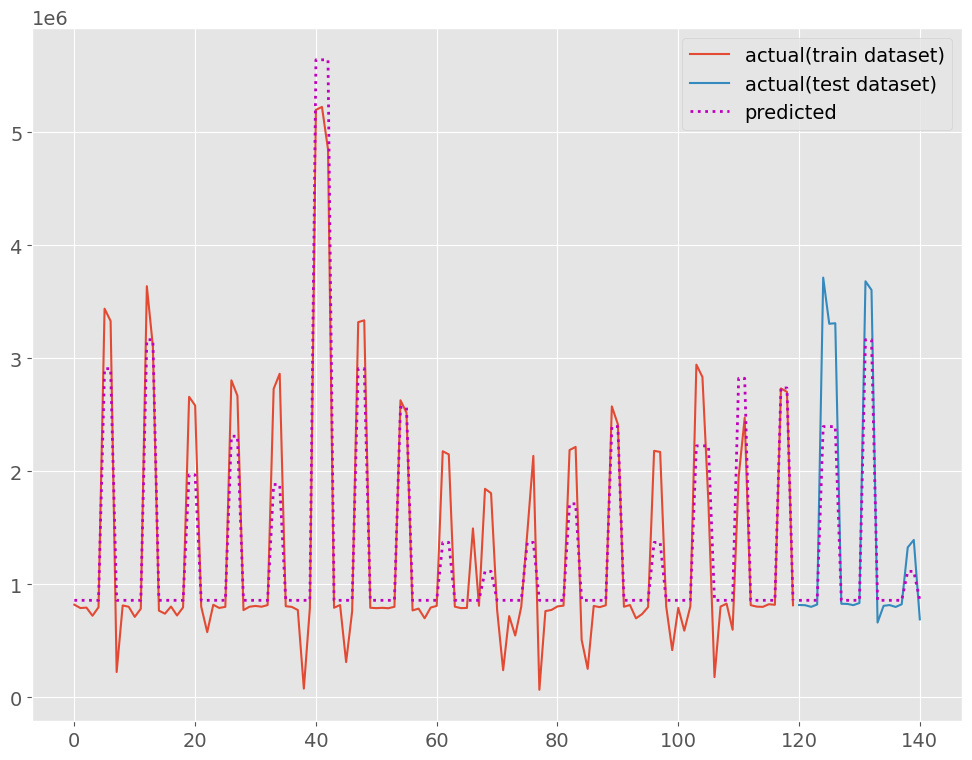

In [13]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(
    y_train.index, 
    y_train.values, 
    label="actual(train dataset)")
ax.plot(
    y_test.index, 
    y_test.values, 
    label="actual(test dataset)")
ax.plot(
    y_train.index, 
    train_pred, 
    linestyle="dotted", 
    lw=2,
    color="m")
ax.plot(
    y_test.index, 
    test_pred, 
    label="predicted", 
    linestyle="dotted", 
    lw=2, 
    color="m") 

plt.legend()
plt.show()

#### PLS回帰

In [14]:
#
# ハイパーパラメータ探索
#

# PLS回帰のインスタンス生成
regressor = PLSRegression()

# 探索するハイパーパラメータ範囲の設定
params = {
    'n_components':
        IntDistribution(1, len(X_train.columns))
}

# ハイパーパラメータ探索の設定
optuna_search = OptunaSearchCV(
    estimator=regressor,
    param_distributions=params,
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=123)

# 探索実施
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search.fit(X_train, y_train)

# 探索結果
print(optuna_search.best_params_)

{'n_components': 5}


In [15]:
#
# 最適ハイパーパラメータで学習
#

# 最適なハイパーパラメータを設定
PLS_p1 = regressor.set_params(**optuna_search.best_params_)

# 学習データで学習
PLS_p1.fit(X_train, y_train)

# 切片と回帰係数
print('切片:',PLS_p1.intercept_)
print('回帰係数:',PLS_p1.coef_)

切片: [1340566.5]
回帰係数: [[  -6526.62390982]
 [-186295.93558883]
 [ 442843.51625541]
 [ 351891.02126011]
 [ 316117.69940159]]


In [16]:
#
# テストデータで精度評価
#

# 予測
train_pred = PLS_p1.predict(X_train)
test_pred = PLS_p1.predict(X_test)

# 精度指標（テストデータ）
print('RMSE:\n',np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:\n',mean_absolute_error(y_test, test_pred))
print('MAPE:\n',mean_absolute_percentage_error(y_test, test_pred))

RMSE:
 26138.600169956095
MAE:
 16289.280312699155
MAPE:
 0.008169169500944599


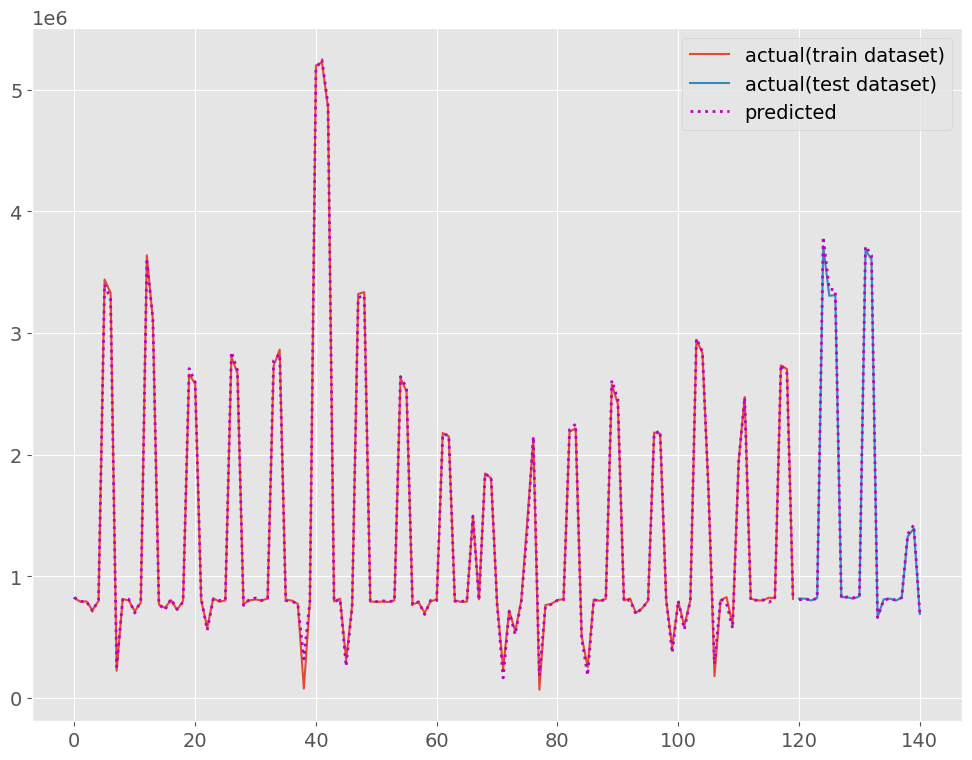

In [17]:
#
# グラフ化
#

fig, ax = plt.subplots()

ax.plot(
    y_train.index, 
    y_train.values, 
    label="actual(train dataset)")
ax.plot(
    y_test.index, 
    y_test.values, 
    label="actual(test dataset)")
ax.plot(
    y_train.index, 
    train_pred, 
    linestyle="dotted", 
    lw=2,
    color="m")
ax.plot(
    y_test.index, 
    test_pred, 
    label="predicted", 
    linestyle="dotted", 
    lw=2, 
    color="m") 

plt.legend()
plt.show()

### 関数化

In [18]:
#
# 予測モデルを学習しその結果を返す関数
#

'''
関数名:
    prediction_model_generation
引数:
    regressor　学習器
    y_train　学習データの目的変数y
    X_train　学習データの説明変数X
    y_test　テストデータの目的変数y
    X_test　テストデータの説明変数X
戻値：
    train_pred　学習データの予測結果
    test_pred　テストデータの予測結果
    rmse　RMSE（精度評価指標）
    mae　MAE（精度評価指標）
    mape　MAPE（精度評価指標）
'''

def prediction_model_generation(regressor,y_train, X_train, y_test, X_test):

    # PLS回帰のインスタンス生成
    regressor = regressor

    # 探索するハイパーパラメータ範囲の設定
    if type(regressor) == PLSRegression:
        params = {
            'n_components':
                IntDistribution(1, len(X_train.columns))
        }
    elif type(regressor) == Ridge:
        params = {
            'alpha': FloatDistribution(0.001, 1e10)
        }
    else:
        return

    # ハイパーパラメータ探索の設定
    optuna_search = OptunaSearchCV(
        estimator=regressor,
        param_distributions=params,
        n_trials=1000,
        cv=TimeSeriesSplit(),
        random_state=123)

    # 探索実施
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna_search.fit(X_train, y_train)

    # 最適なハイパーパラメータを設定
    model = regressor.set_params(**optuna_search.best_params_)

    # 学習データで学習
    model.fit(X_train, y_train)

    # 予測
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # 精度指標（テストデータ）
    rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    mae = mean_absolute_error(y_test, test_pred)
    mape = mean_absolute_percentage_error(y_test, test_pred)
    
    # 戻値
    return train_pred,test_pred,rmse,mae,mape

In [19]:
#
# 予測結果を折れ線グラフで描写する関数
#

'''
関数名:
    predicted_result_graphical_representation
引数:
    y_train　学習データの目的変数y
    y_test　テストデータの目的変数y
    train_pred　学習データの予測結果
    test_pred　テストデータの予測結果
'''

def predicted_result_graphical_representation(y_train, y_test, train_pred, test_pred):

    fig, ax = plt.subplots()

    ax.plot(
        y_train.index, 
        y_train.values, 
        label="actual(train dataset)")
    ax.plot(
        y_test.index, 
        y_test.values, 
        label="actual(test dataset)")
    ax.plot(
        y_train.index, 
        train_pred, 
        linestyle="dotted", 
        lw=2,
        color="m")
    ax.plot(
        y_test.index, 
        test_pred, 
        label="predicted", 
        linestyle="dotted", 
        lw=2, 
        color="m") 

    plt.legend()
    plt.show()

### パターン2：説明変数x1からx4、休日フラグ変数（holiday）、曜日ダミー変数

#### 目的変数yと説明変数X

In [20]:
#
# パターン2｜目的変数yと説明変数X
#

# 変数選択リスト（True:変数として残す）
x_list = [
    False,False,False,False,False,
    True,True,True,True,True, #x1,x2,x3,x4,holiday
    True,True,True,True,True,True,True, #day_of_the_week
    False,False,False,False,False,False #Fourier terms
]

print(df[df.columns[x_list]]) #確認

# 学習データ
y_train = df_train.y1
X_train = df_train[df.columns[x_list]]

# テストデータ
y_test = df_test.y1
X_test = df_test[df.columns[x_list]]

       x1    x2     x3    x4  holiday  Tue  Wed  Thu  Fri  Sat  Sun  Mon
0    18.3   0.0  0.006     0        0    0    0    0    0    0    0    1
1    19.8   0.9  0.002     0        0    1    0    0    0    0    0    0
2    22.8   0.5  0.002     0        0    0    1    0    0    0    0    0
3    23.1   7.0  0.005     0        0    0    0    1    0    0    0    0
4    22.2   0.0  0.003     0        0    0    0    0    1    0    0    0
..    ...   ...    ...   ...      ...  ...  ...  ...  ...  ...  ...  ...
136  20.8   0.0  0.002     0        0    0    0    1    0    0    0    0
137  17.8   0.5  0.007     0        0    0    0    0    1    0    0    0
138  17.7  82.9  0.229  7500        1    0    0    0    0    1    0    0
139  16.9  76.5  0.225  7500        1    0    0    0    0    0    1    0
140  17.3  10.8  0.010     0        0    0    0    0    0    0    0    1

[141 rows x 12 columns]


#### Ridge回帰

RMSE:
 440558.53750772617
MAE:
 259480.62707756148
MAPE
 0.12744831069881785


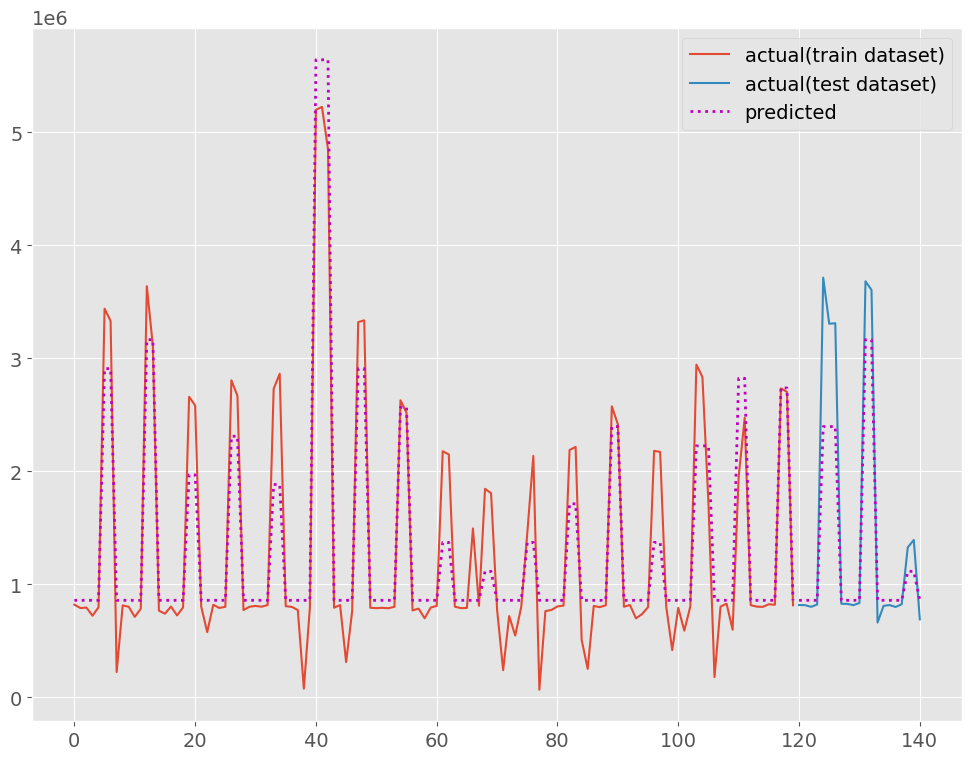

In [21]:
#
# パターン2｜Ridge回帰
#

# 学習と評価の実施
train_pred, test_pred, rmse, mae, mape= prediction_model_generation(
    Ridge(), 
    y_train, X_train,
    y_test, X_test)

# 精度指標（テストデータ）
print('RMSE:\n', rmse)
print('MAE:\n', mae)
print('MAPE\n', mape)

# 結果描写
predicted_result_graphical_representation(
    y_train, y_test, train_pred, test_pred)

#### PLS回帰

RMSE:
 25811.194401887748
MAE:
 14744.536736766697
MAPE
 0.006547528395273901


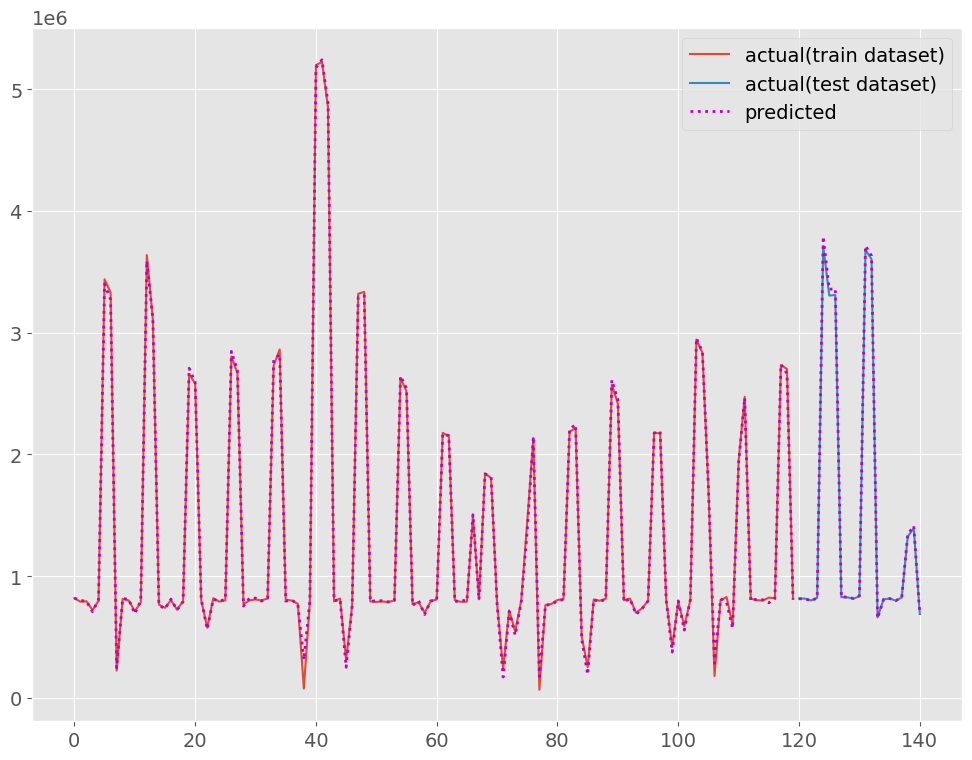

In [22]:
#
# パターン2｜PLS回帰
#

# 学習と評価の実施
train_pred, test_pred, rmse, mae, mape = prediction_model_generation(
    PLSRegression(),
    y_train, X_train,
    y_test, X_test)

# 精度指標（テストデータ）
print('RMSE:\n', rmse)
print('MAE:\n', mae)
print('MAPE\n', mape)

# 結果描写
predicted_result_graphical_representation(
    y_train, y_test,train_pred, test_pred)

### パターン3：説明変数x1からx4、休日フラグ変数（holiday）、三角関数特徴量

#### 目的変数yと説明変数X

In [23]:
#
# パターン3｜目的変数yと説明変数X
#

# 変数選択リスト（True:変数として残す）
x_list = [
    False,False,False,False,False,
    True,True,True,True,True, #x1,x2,x3,x4,holiday
    False,False,False,False,False,False,False, #day_of_the_week
    True,True,True,True,True,True #Fourier terms
]

print(df[df.columns[x_list]]) #確認

# 学習データ
y_train = df_train.y1
X_train = df_train[df.columns[x_list]]

# テストデータ
y_test = df_test.y1
X_test = df_test[df.columns[x_list]]

       x1    x2     x3    x4  holiday        sin7_1    cos7_1        sin7_2  \
0    18.3   0.0  0.006     0        0  0.000000e+00  1.000000  0.000000e+00   
1    19.8   0.9  0.002     0        0  7.818315e-01  0.623490  9.749279e-01   
2    22.8   0.5  0.002     0        0  9.749279e-01 -0.222521 -4.338837e-01   
3    23.1   7.0  0.005     0        0  4.338837e-01 -0.900969 -7.818315e-01   
4    22.2   0.0  0.003     0        0 -4.338837e-01 -0.900969  7.818315e-01   
..    ...   ...    ...   ...      ...           ...       ...           ...   
136  20.8   0.0  0.002     0        0  4.338837e-01 -0.900969 -7.818315e-01   
137  17.8   0.5  0.007     0        0 -4.338837e-01 -0.900969  7.818315e-01   
138  17.7  82.9  0.229  7500        1 -9.749279e-01 -0.222521  4.338837e-01   
139  16.9  76.5  0.225  7500        1 -7.818315e-01  0.623490 -9.749279e-01   
140  17.3  10.8  0.010     0        0 -4.898587e-15  1.000000 -9.797174e-15   

       cos7_2        sin7_3    cos7_3  
0    1.0000

#### Ridge回帰

RMSE:
 440558.5368304438
MAE:
 259480.62585374186
MAPE
 0.12744830952097214


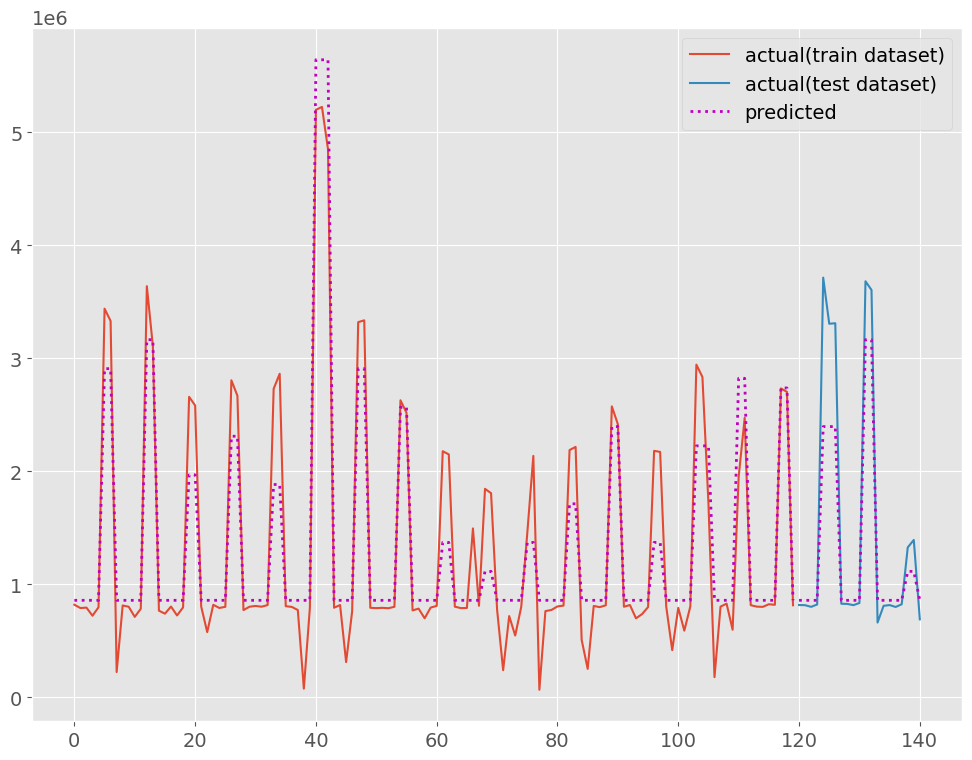

In [24]:
#
# パターン3｜Ridge回帰
#

# 学習と評価の実施
train_pred, test_pred, rmse, mae, mape = prediction_model_generation(
    Ridge(),
    y_train, X_train, 
    y_test, X_test)

# 精度指標（テストデータ）
print('RMSE:\n', rmse)
print('MAE:\n', mae)
print('MAPE\n', mape)

# 結果描写
predicted_result_graphical_representation(
    y_train, y_test, train_pred, test_pred)

#### PLS回帰

RMSE:
 26483.566069970737
MAE:
 15531.593241984883
MAPE
 0.007312407992935514


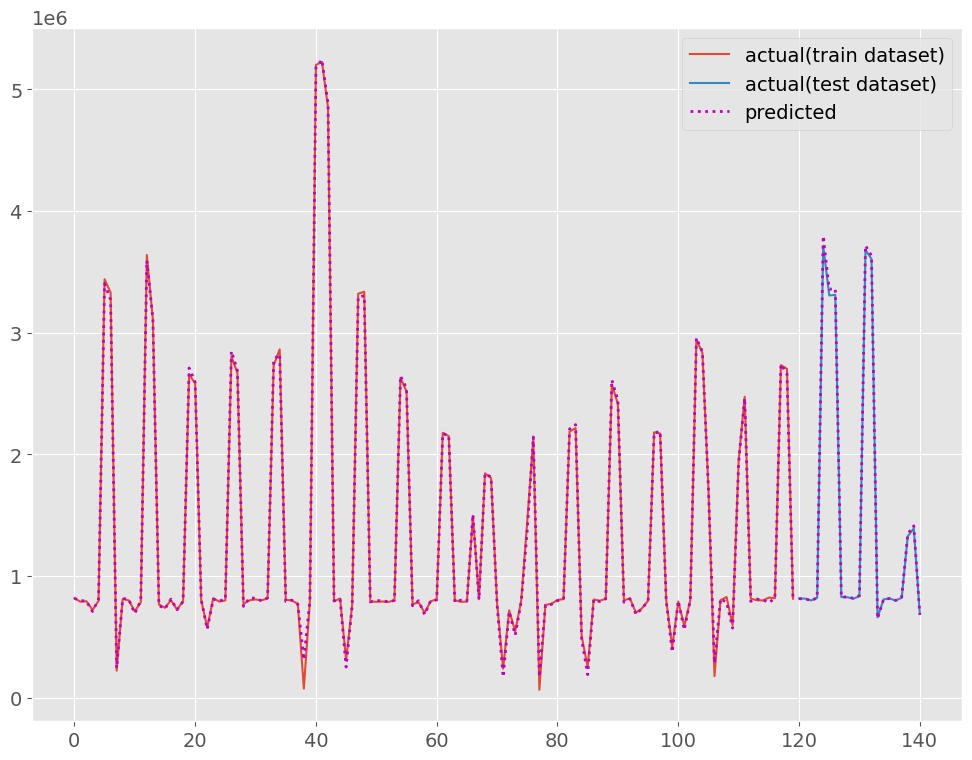

In [25]:
#
# パターン3｜PLS回帰
#

# 学習と評価の実施
train_pred, test_pred, rmse, mae, mape = prediction_model_generation(
    PLSRegression(),
    y_train, X_train, 
    y_test, X_test)

# 精度指標（テストデータ）
print('RMSE:\n', rmse)
print('MAE:\n', mae)
print('MAPE\n', mape)

# 結果描写
predicted_result_graphical_representation(
    y_train, y_test, train_pred, test_pred)

## ステップ3：予測モデルの構築

### パターン2の説明変数を使いPLS回帰で構築

In [26]:
#
# パターン2の説明変数を使いPLS回帰で構築
#

# 変数選択リスト（True:変数として残す）
x_list = [
    False,False,False,False,False,
    True,True,True,True,True, #x1,x2,x3,x4,holiday
    True,True,True,True,True,True,True, #day_of_the_week
    False,False,False,False,False,False #Fourier terms
]

# 学習データ（全データ）
y = df.y1
X = df[df.columns[x_list]]

# PLS回帰のインスタンス生成
regressor = PLSRegression()

# 探索するハイパーパラメータ範囲の設定
params = {
    'n_components':
        IntDistribution(1, len(X_train.columns))
}

# ハイパーパラメータ探索の設定
optuna_search = OptunaSearchCV(
    estimator=regressor,
    param_distributions=params,
    n_trials=1000,
    cv=TimeSeriesSplit(),
    random_state=123)

# 探索実施
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_search.fit(X, y)

# 最適なハイパーパラメータを設定
PLS_p2 = regressor.set_params(**optuna_search.best_params_)

# 学習データで学習
PLS_p2.fit(X, y)

# 切片と回帰係数
print('切片:\n',PLS_p2.intercept_)
print('回帰係数:\n',PLS_p2.coef_)

切片:
 [1364223.53191489]
回帰係数:
 [[-4.77013815e+03]
 [-2.13580737e+05]
 [ 4.63464895e+05]
 [ 3.52885358e+05]
 [ 3.20089874e+05]
 [ 3.72514891e+03]
 [ 3.28339691e+02]
 [-1.08874628e+03]
 [ 1.66493872e+03]
 [ 1.48883907e+01]
 [-2.53551786e+03]
 [-2.06678172e+03]]


In [27]:
#
# 予測結果（学習データ）
#

# 予測
pred = PLS_p2.predict(X)

# 精度指標（テストデータ）
print('RMSE:\n', np.sqrt(mean_squared_error(y, pred)))
print('MAE:\n', mean_absolute_error(y, pred))
print('MAPE:\n', mean_absolute_percentage_error(y, pred))

RMSE:
 32029.938530962012
MAE:
 17182.161129568318
MAPE:
 0.05436955840028377


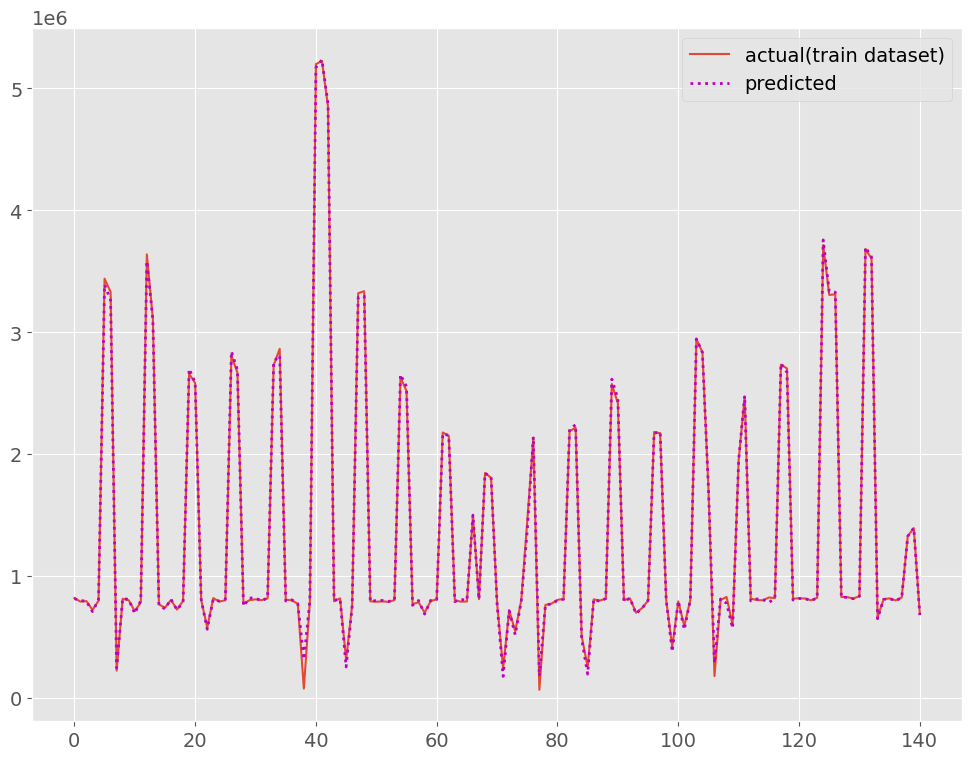

In [28]:
#
# グラフ化（学習データ）
#

fig, ax = plt.subplots()

ax.plot(y.index, 
        y.values, 
        label="actual(train dataset)")
ax.plot(y.index, 
        pred, 
        label="predicted", 
        linestyle="dotted", 
        lw=2, 
        color="m") 

plt.legend()
plt.show()

### 構築したモデルの保存と読み込み

In [29]:
#
# 構築したモデルの保存
#

import pickle

filename = 'model.pkl'
pickle.dump(PLS_p2, open(filename,'wb'))

In [30]:
#
# 保存したモデルの読み込み
#

import pickle

filename = 'model.pkl' 
PLS_p2 = pickle.load(open(filename, 'rb'))

## ステップ4：各施策プラン案に対する売上予測

### データセットの読み込み

In [31]:
#
# 各施策プラン案のデータセットの読み込み
#

dataset = 'chap5_3.csv'
df_plan = pd.read_csv(dataset)

print(df_plan) #確認

     plan        date day_of_the_week    x1   x2   x3     x4  holiday
0   planA  2016/10/25             Tue  20.6  3.8  0.0      0        0
1   planA  2016/10/26             Wed  21.0  3.7  0.0      0        0
2   planA  2016/10/27             Thu  20.4  0.5  0.0      0        0
3   planA  2016/10/28             Fri  18.5  0.0  0.0      0        0
4   planA  2016/10/29             Sat  17.1  0.0  0.2  75000        1
5   planA  2016/10/30             Sun  16.7  0.0  0.2  75000        1
6   planA  2016/10/31             Mon  17.3  9.3  0.0      0        0
7   planB  2016/10/25             Tue  20.6  3.8  0.0      0        0
8   planB  2016/10/26             Wed  21.0  3.7  0.0      0        0
9   planB  2016/10/27             Thu  20.4  0.5  0.0      0        0
10  planB  2016/10/28             Fri  18.5  0.0  0.0      0        0
11  planB  2016/10/29             Sat  17.1  0.0  0.0  75000        1
12  planB  2016/10/30             Sun  16.7  0.0  0.0  75000        1
13  planB  2016/10/3

### 曜日ダミー変数を作る

In [32]:
#
# 曜日のダミー変数（One-Hotエンコーディング）生成
#

# 曜日リスト
week_list = ['Tue','Wed','Thu','Fri','Sat','Sun','Mon']

# One-Hotエンコーディングの実施
week_d = enc.transform(df_plan[['day_of_the_week']])

# データフレーム化
df_week_d = pd.DataFrame(
    week_d,
    index=df_plan.index,
    columns=week_list,
    dtype='int')

# 元のデータセットに結合
df_plan = pd.concat([df_plan, df_week_d], axis=1)

print(df_plan.head()) #確認

    plan        date day_of_the_week    x1   x2   x3     x4  holiday  Tue  \
0  planA  2016/10/25             Tue  20.6  3.8  0.0      0        0    1   
1  planA  2016/10/26             Wed  21.0  3.7  0.0      0        0    0   
2  planA  2016/10/27             Thu  20.4  0.5  0.0      0        0    0   
3  planA  2016/10/28             Fri  18.5  0.0  0.0      0        0    0   
4  planA  2016/10/29             Sat  17.1  0.0  0.2  75000        1    0   

   Wed  Thu  Fri  Sat  Sun  Mon  
0    0    0    0    0    0    0  
1    1    0    0    0    0    0  
2    0    1    0    0    0    0  
3    0    0    1    0    0    0  
4    0    0    0    1    0    0  


In [33]:
#
# コストのデータセットの読み込み
#

dataset = 'chap5_4.csv'
df_cost = pd.read_csv(dataset, index_col='plan')

# 確認
print(df_cost)

          cost
plan          
planA  4650202
planB   750000
planC  3675508
planD        0


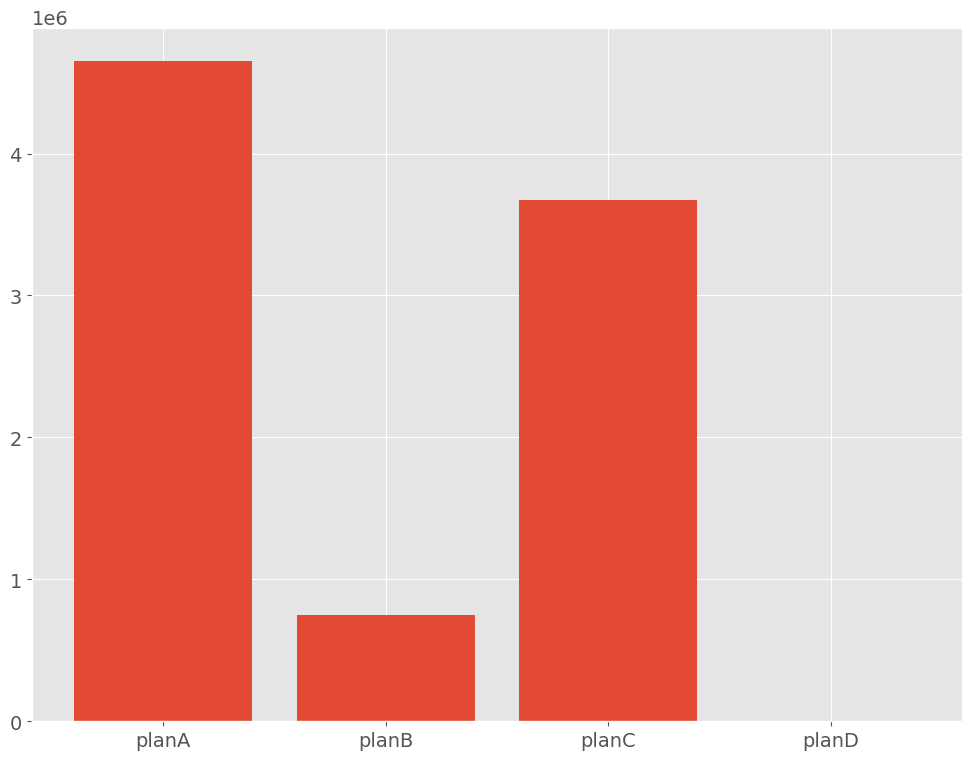

In [34]:
#
# グラフ化
#

plt.bar(
    np.array([1, 2, 3, 4]),
    df_cost.cost,
    tick_label=df_cost.index)

plt.show()

### プランAの売上予測

In [35]:
#
# 利用する説明変数Xの設定
#

plan = 'planA'
X_plan = df_plan[df_plan.plan == plan].iloc[:,3:]

print(X_plan) #確認

     x1   x2   x3     x4  holiday  Tue  Wed  Thu  Fri  Sat  Sun  Mon
0  20.6  3.8  0.0      0        0    1    0    0    0    0    0    0
1  21.0  3.7  0.0      0        0    0    1    0    0    0    0    0
2  20.4  0.5  0.0      0        0    0    0    1    0    0    0    0
3  18.5  0.0  0.0      0        0    0    0    0    1    0    0    0
4  17.1  0.0  0.2  75000        1    0    0    0    0    1    0    0
5  16.7  0.0  0.2  75000        1    0    0    0    0    0    1    0
6  17.3  9.3  0.0      0        0    0    0    0    0    0    0    1


In [36]:
#
# 売上予測の実施
#

pred = PLS_p2.predict(X_plan) #予測の実施
sum_pred = np.sum(pred) #予測の合計

# 確認
print('daily:\n',pred)
print('total:\n',sum_pred)

daily:
 [[ 749200.75863256]
 [ 740426.7755165 ]
 [ 782141.36058054]
 [ 799324.16845687]
 [3240571.0979947 ]
 [3233767.0873246 ]
 [ 659322.18040797]]
total:
 10204753.42891374


In [37]:
#
# 予測結果をデータフレームへ格納
#

# データフレームの生成
pred_tbl = pd.DataFrame(
    index = df_cost.index,
    columns = ['predicted'])

# 予測結果の格納
pred_tbl.loc[plan,'predicted'] = sum_pred

print(pred_tbl) #確認

             predicted
plan                  
planA  10204753.428914
planB              NaN
planC              NaN
planD              NaN


### 関数化

In [38]:
#
# 予測関数
#

'''
関数名:
    predicted_sales
引数:
    df_plan　計画のデータセット
    plan　プラン指定
    pred_tbl　予測結果を格納するデータフレーム
'''
def predicted_sales(df_plan, plan, pred_tbl):
    X_plan = df_plan[df_plan.plan == plan].iloc[:,3:] #説明変数Xの設定
    pred = PLS_p2.predict(X_plan) #予測の実施
    sum_pred = np.sum(pred) #予測の合計
    pred_tbl.loc[plan,'predicted'] = sum_pred #結果格納

### 残りの施策プラン案の予測実施

In [39]:
#
# 残りの施策プラン案（planB, planC, planD）の予測実施
#

plan_list = ['planB', 'planC', 'planD']

for plan in plan_list:
    predicted_sales(df_plan, plan, pred_tbl)
    
print(pred_tbl) #確認

             predicted
plan                  
planA  10204753.428914
planB   8603308.029109
planC   8286105.068745
planD   6684659.668939


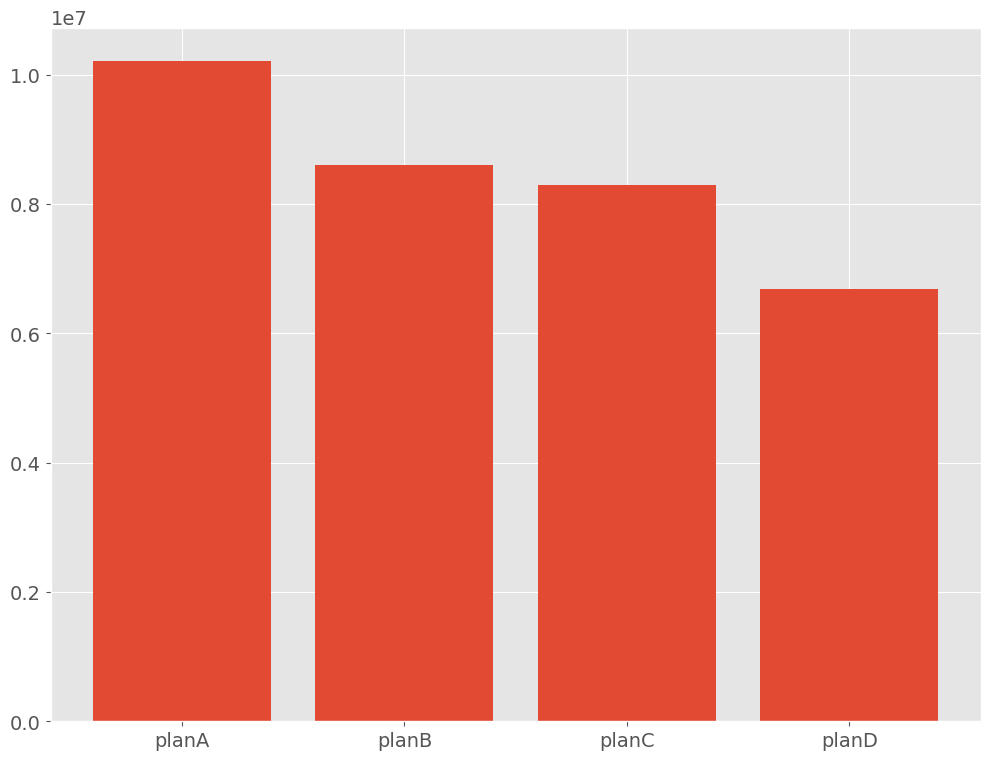

In [40]:
#
# グラフ化
#

plt.bar(
    np.array([1, 2, 3, 4]),
    pred_tbl.predicted,
    tick_label=pred_tbl.index)

plt.show()

## ステップ5：各施策プラン案に対するマーケティングROI算定

In [41]:
#
# 各施策プラン案に対するマーケティングROIの算定
#

mROI = ((pred_tbl-pred_tbl.loc["planD"]).predicted - df_cost.cost) / df_cost.cost

print(mROI) #確認

plan
planA   -0.243023
planB    1.558198
planC   -0.564293
planD         NaN
dtype: object


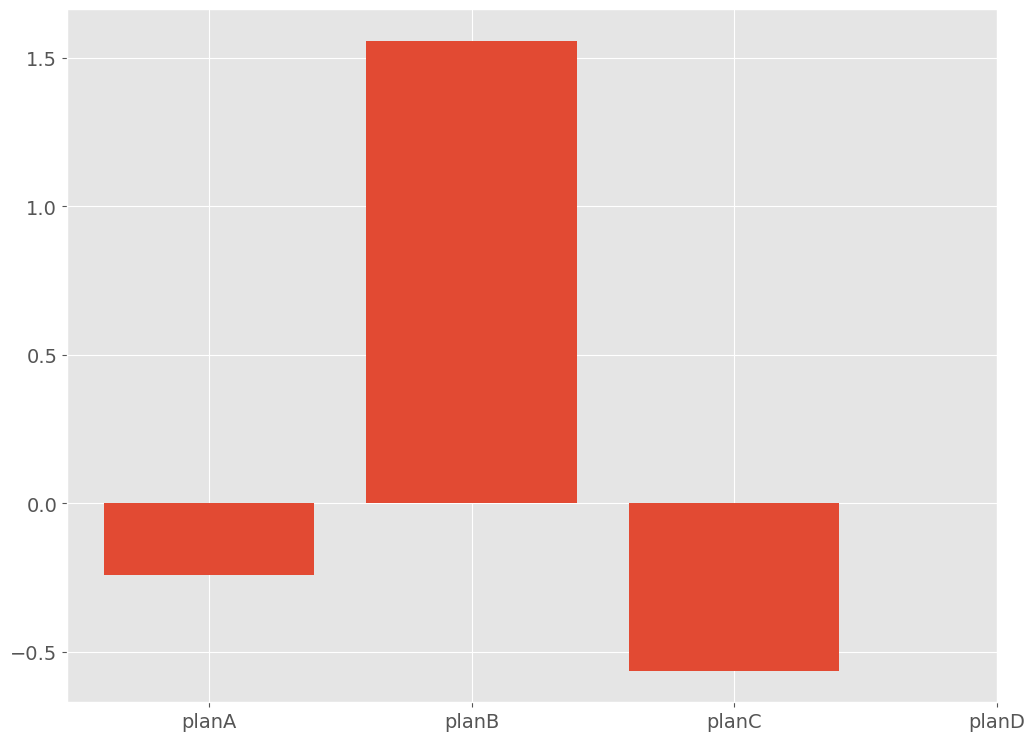

In [42]:
#
# グラフ化
#

plt.bar(
    np.array([1, 2, 3, 4]),
    mROI,
    tick_label=mROI.index)

plt.show()